In [3]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pyross
import pandas as pd

In [5]:
import cma
import nlopt
import pathos

## Denmark age and contact matrix

In [6]:
my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;

M=16  ## number of age classes

Ni = Ni0[:M]
N=np.sum(Ni)

print("Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).")
print("Number of individuals in each bracket:")
print(Ni.astype('int'))
print("Total number of individuals: {0}".format(np.sum(Ni.astype('int'))))

Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).
Number of individuals in each bracket:
[302353 305513 338779 341219 379522 395469 342443 320132 366147 385944
 422585 381360 338039 319145 346572 220374]
Total number of individuals: 5505596


In [7]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.Denmark()

# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO


C is the sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$

We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of UK obtained from the *Population pyramid* website.

# Fit with real data

In [8]:
# Get the latest data from Johns Hopkins University
!git clone https://github.com/CSSEGISandData/COVID-19

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [9]:
cases = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,789,795,803,820,832,842,850,856,868,872
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,747,748,750,751,751,752,752,754,755,755
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,35,35,35,36,36,36,43,43,45,45


In [10]:
deaths = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths.shape

(266, 115)

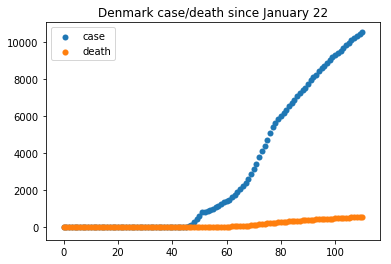

In [11]:
cols = cases.columns.tolist() 
case = cases.loc[94,][4:]
death = deaths.loc[94,][4:]
plt.scatter(np.arange(len(case)),case, label= 'case',lw=0.01);
plt.scatter(np.arange(len(death)),death, label='death', lw=0.1);
plt.title('Denmark case/death since January 22')
plt.legend();

## Using data from the repo

In [12]:
import pandas as pd
import time
# pd.read_csv('addbyme/denmark_cases_by_age.csv')

In [13]:
denmark_age_structured_case = pd.read_csv('../data/covid-cases/denmark_cases_by_age.csv')
denmark_age_structured_case.tail(10)

,Unnamed: 0,2020-03-13,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,...,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05
0,0-9,10,12,13,12,13,13,13,13,13,...,108,111,116,120,126,135,139,143,155,168
1,10-19,30,33,33,33,35,35,35,35,35,...,273,284,298,313,326,336,345,347,363,378
2,20-29,134,140,142,146,148,153,161,165,167,...,1093,1112,1139,1160,1188,1227,1244,1265,1287,1308
3,30-39,135,143,147,156,162,170,184,191,193,...,1162,1181,1199,1230,1262,1284,1302,1315,1339,1368
4,40-49,253,284,294,305,325,345,362,375,386,...,1600,1616,1644,1673,1687,1706,1719,1734,1757,1778
5,50-59,159,176,186,200,209,224,239,248,254,...,1637,1656,1682,1694,1714,1733,1755,1780,1805,1833
6,60-69,50,62,70,90,107,127,140,148,156,...,1068,1074,1090,1106,1122,1137,1141,1155,1164,1178
7,70-79,5,26,39,55,70,82,100,118,132,...,806,819,825,833,842,848,851,864,871,876
8,80-89,7,18,28,38,51,65,77,87,98,...,628,642,649,666,673,682,685,693,701,706
9,90+,2,4,8,9,12,12,15,15,16,...,200,203,209,213,218,223,226,227,228,228


In [14]:
l = denmark_age_structured_case.sum(axis=0)
case = l[1:]



In [15]:
denmark_age_structured_case.shape

(10, 53)

## Infer latent parameters of the SEAI5R model for Denmark

In [16]:
## infective people
nbday = denmark_age_structured_case.shape[1]-1
nbgroup = denmark_age_structured_case.shape[0]
I = np.array(np.zeros([nbgroup,nbday]))
for i in range(nbgroup):
    I[i] = np.array([denmark_age_structured_case.loc[i][1:nbday+1]])

The contact matrix is given for 16 groups from 0 to 80 years old. We will take the 1st 7th group in the data above and divide each group in two.

In [17]:
##  duplicate for each subgroup of age 
M = 16
Is = np.array([val for val in I[:8]/2 for _ in (0, 1)])

In [18]:
## take only integer values, loosing cases !
for j in range(Is.shape[0]):
    Is[j] = np.array([int(i) for i in Is[j]])

We can infer R0  as a fraction of school contact reduction and determine the critical value needed to bring R0 below 1. 

### Run 1st simulation

In [19]:
beta  = 0.036692            # infection rate 

gE    = 1/5.
gA    = 1/4.
gIa   = 1./3.                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.4                 # fraction of asymptomatic infectives 
fsa   = 0.2                 # the self-isolation parameter   
fh    = 0
gIh   = 1/7
gIc   = 1/14
 
sa    = 0*np.ones(M)      #  rate of additional/removal of population by birth etc
# sa[0]     = 0            # birth
# sa[3] = 0          # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
# hh[:M] = 0.01
# hh[M:2*M] = 0.025
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC

# fraction of population in Age group
fi = Ni/sum(Ni)
Ni = N *fi

# initial conditions    
# Is_0 = np.zeros((M)); 
Is_0 = Is[:,0]
 
Ia_0 = 10*np.ones((M))# start with 10 asymptomatic infectives
# Ia_0 = 10*np.ones((M)) # same number of asymptomatic infectives and symptomatic infectives


R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))




S_0  = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Ih_0 + Ic_0 +Im_0 + R_0)

In [20]:
# N = int(N)

### Full contact matrix C

In [21]:
## full matrix C
def contactMatrix(t):
    return C

In [22]:
# time_points to solve the ode (using odeint) Ti = 0 by default 
Tf=350;  Nf=Tf+2;  
# Tf=350;  Nf=3500;  #Tf is the final day np.linspace(Ti, Tf, Nf) 
# 1 day = 3

In [ ]:
# simulate model - 25 min to run
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.stochastic.SEAI5R(parameters, M, Ni.copy())

# run model 
data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                    contactMatrix, Tf, Nf)

In [ ]:
data_array = data['X']
t = data['t']
np.save('SEAI5R_latent_traj.npy', data_array)

In [ ]:
data_array.shape

IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i]

In [ ]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, Tf, 90), ('22/01', '30/04'  ));

day, cases = np.array(np.arange(1,Tf)), np.array(case[0:Tf])
plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)
plt.legend(fontsize=15, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals');
plt.title('Infer using the first Is0 only');

# plt.savefig('FullmatrixC.png', format='png', dpi=200)

### Infer latent parameters using first observations for Infective

In [ ]:
# load the data 
x = np.load('SEAI5R_latent_traj.npy').astype('float') # 9 equations * 16
x.shape

In [ ]:
x

In [ ]:
steps = 101 # number internal integration steps taken

In [ ]:
# obs used for inference 
Tf_inference = 10
Nf_inference = Tf_inference + 1
x = x[:Nf_inference,:8*M]/N # remove the last equation only
x.shape 

In [ ]:
# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

In [ ]:
## create filter to distinguish between observable classes
fltr=np.repeat(np.array([False, False, False, False, True, True, True, True]), M) # take only 4 equations
obs=x[:,fltr]
x0 = x[0]
obs.shape

In [ ]:
# set up initial condition
Ia0 = Ia_0  # each age group has asymptomatic infectives
Is0 = Is_0    # and also symptomatic infectives
R0  = R_0
E0  = E_0 
A0  = A_0 
Ih0  = np.zeros((M))
Ic0  = np.zeros((M))
Im0  = np.zeros((M))
S0  = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

eps = 1e-4 

alpha_g = 0.25          
alpha_std = 0.1
alpha_b = (0.05, 0.5)

beta_g  = 0.06         
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (eps, 0.5)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (eps, 0.5) 

gE_g    = 0.21 
gE_std = 0.05
gE_b = (0.1, 0.3)

gA_g    = 0.35 
gA_std = 0.05 
gA_b = (0.2, 0.5) 
   

E0_g = (E0+3)/N
E0_std = E0_g
E0_b = [[0.1/N, 100/N]]*M 

A0_g  = (A0+3)/N
A0_std = A0_g
A0_b = [[0.1/N, 100/N]]*M

Ia0_g = (Ia0+0.2)/N 
Ia0_std = [5/N]*M
Ia0_b = [(0.1/N, 100/N)]*M

Is0_g = (Is0+0.1)/N 
Is0_std = [5/N]*M  
Is0_b = [(0.1/N, 100/N)]*M

Ih0_g = (Ih0+0.1)/N 
Ih0_std = [5/N]*M 
Ih0_b = [(0.1/N, 100/N)]*M

Ic0_g = (Ic0+0.1)/N 
Ic0_std = [5/N]*M 
Ic0_b = [(0.1/N, 100/N)]*M

Im0_g = (Im0+0.1)/N 
Im0_std = [5/N]*M 
Im0_b = [(0.1/N, 100/N)]*M

S0_g = (S0-10)/N 
S0_std = E0_std*4 
S0_b = [(1/N, f) for f in fi]



# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)   
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b, 
                   *S0_b, *E0_b, *A0_b, *Ia0_b, *Is0_b, *Ih0_b, *Ic0_b, *Im0_b])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g, 
                   *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g, *Ih0_g, *Ic0_g, *Im0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std, 
                 *S0_std, *E0_std, *A0_std, *Ia0_std, *Is0_std, *Ih0_std, *Ic0_std, *Im0_std])


In [ ]:
bounds

In [56]:
start_time = time.time()
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    global_max_iter=30, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...


ValueError: argument of inverse must be within the given bounds

In [ ]:
# save the parameters 
np.save('SEAI5R_latent_param.npy', params)

In [ ]:
print('True parameters')
print(parameters)

params = np.load('SEAI5R_latent_param.npy')
best_estimates = estimator.make_params_dict(params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0)
print('\n Inferred initial conditons: ') 
print((params[6:]*N).astype('int'))

In [ ]:
# Compare inferred trajectories to true trajectories 
x0 = params[6:]
det_model = pyross.deterministic.SEAI5R(best_estimates, int(M), fi)
estimator.set_params(best_estimates)
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('SEAI5R_latent_traj.npy').astype('float')[:, :8*M]/N

plt.plot(np.sum(x[:,M:4*M], axis=1), label='True unknown infective')
plt.plot(np.sum(x_det[:,M:4*M], axis=1), label='Inferred unknown infective')
plt.plot(np.sum(x[:,4*M:], axis=1), label='True known infectives')
plt.plot(np.sum(x_det[:, 4*M:], axis=1), label='Inferred known infectives')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show()

### Infer R0

In [40]:
# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (1.9895942318700701+0j)


In [43]:
len(np.linalg.eigvals(L))

32